<a href="https://colab.research.google.com/github/YolandaMDavis/wildtrack-iqa/blob/task-amenability/cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Image Feature Cluster Analysis

### In this notebook we are looking to discover features or charateristics within an image that may form clusters along subjective scores

In [1]:
# Pull data from shared google drive
import shutil

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy and extract tar file
shutil.copy(PARENT_DIR + '/data/WildTrack_Raw.zip', 'WildTrack_Raw.zip')

Mounted at /content/drive


'WildTrack_Raw.zip'

## Define Brisque Calculations

Using brisque calculations sourced from #website#, we will generate the features from footprint images to create matrix for analysis

In [4]:
import math
import scipy.special
import numpy as np
import cv2
import scipy as sp

gamma_range = np.arange(0.2, 10, 0.001)
a = scipy.special.gamma(2.0/gamma_range)
a *= a
b = scipy.special.gamma(1.0/gamma_range)
c = scipy.special.gamma(3.0/gamma_range)
prec_gammas = a/(b*c)


def aggd_features(imdata):
    # flatten imdata
    imdata.shape = (len(imdata.flat),)
    imdata2 = imdata*imdata
    left_data = imdata2[imdata < 0]
    right_data = imdata2[imdata >= 0]
    left_mean_sqrt = 0
    right_mean_sqrt = 0
    if len(left_data) > 0:
        left_mean_sqrt = np.sqrt(np.average(left_data))
    if len(right_data) > 0:
        right_mean_sqrt = np.sqrt(np.average(right_data))

    if right_mean_sqrt != 0:
        gamma_hat = left_mean_sqrt/right_mean_sqrt
    else:
        gamma_hat = np.inf
    # solve r-hat norm

    imdata2_mean = np.mean(imdata2)
    if imdata2_mean != 0:
        r_hat = (np.average(np.abs(imdata))**2) / (np.average(imdata2))
    else:
        r_hat = np.inf
    rhat_norm = r_hat * (((math.pow(gamma_hat, 3) + 1) *
                          (gamma_hat + 1)) / math.pow(math.pow(gamma_hat, 2) + 1, 2))

    # solve alpha by guessing values that minimize ro
    pos = np.argmin((prec_gammas - rhat_norm)**2)
    alpha = gamma_range[pos]

    gam1 = scipy.special.gamma(1.0/alpha)
    gam2 = scipy.special.gamma(2.0/alpha)
    gam3 = scipy.special.gamma(3.0/alpha)

    aggdratio = np.sqrt(gam1) / np.sqrt(gam3)
    bl = aggdratio * left_mean_sqrt
    br = aggdratio * right_mean_sqrt

    # mean parameter
    N = (br - bl)*(gam2 / gam1)  # *aggdratio
    return (alpha, N, bl, br, left_mean_sqrt, right_mean_sqrt)


def ggd_features(imdata):
    nr_gam = 1/prec_gammas
    sigma_sq = np.var(imdata)
    E = np.mean(np.abs(imdata))
    rho = sigma_sq/E**2
    pos = np.argmin(np.abs(nr_gam - rho))
    return gamma_range[pos], sigma_sq


def paired_product(new_im):
    shift1 = np.roll(new_im.copy(), 1, axis=1)
    shift2 = np.roll(new_im.copy(), 1, axis=0)
    shift3 = np.roll(np.roll(new_im.copy(), 1, axis=0), 1, axis=1)
    shift4 = np.roll(np.roll(new_im.copy(), 1, axis=0), -1, axis=1)

    H_img = shift1 * new_im
    V_img = shift2 * new_im
    D1_img = shift3 * new_im
    D2_img = shift4 * new_im

    return (H_img, V_img, D1_img, D2_img)


def calculate_mscn(dis_image):
    dis_image = dis_image.astype(np.float32) 
    ux = cv2.GaussianBlur(dis_image, (7, 7), 7/6)
    ux_sq = ux*ux
    sigma = np.sqrt(np.abs(cv2.GaussianBlur(dis_image**2, (7, 7), 7/6)-ux_sq))

    mscn = (dis_image-ux)/(1+sigma)

    return mscn


def ggd_features(imdata):
    nr_gam = 1/prec_gammas
    sigma_sq = np.var(imdata)
    E = np.mean(np.abs(imdata))
    rho = sigma_sq/E**2
    pos = np.argmin(np.abs(nr_gam - rho))
    return gamma_range[pos], sigma_sq


def extract_brisque_feats(mscncoefs):
    alpha_m, sigma_sq = ggd_features(mscncoefs.copy())
    pps1, pps2, pps3, pps4 = paired_product(mscncoefs)
    alpha1, N1, bl1, br1, lsq1, rsq1 = aggd_features(pps1)
    alpha2, N2, bl2, br2, lsq2, rsq2 = aggd_features(pps2)
    alpha3, N3, bl3, br3, lsq3, rsq3 = aggd_features(pps3)
    alpha4, N4, bl4, br4, lsq4, rsq4 = aggd_features(pps4)
    # print(alpha_m, alpha1)
    return [
        alpha_m, sigma_sq,
        alpha1, N1, lsq1**2, rsq1**2,  # (V)
        alpha2, N2, lsq2**2, rsq2**2,  # (H)
        alpha3, N3, lsq3**2, rsq3**2,  # (D1)
        alpha4, N4, lsq4**2, rsq4**2,  # (D2)
    ]


def brisque(im):
    mscncoefs = calculate_mscn(im)
    features1 = extract_brisque_feats(mscncoefs)
    lowResolution = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)
    features2 = extract_brisque_feats(lowResolution)
    return np.array(features1+features2)



Next we will generate footprint matrix for analysis. Lions and Elephants will be used for initial study. First we'll start by loading images into memory and resizing for further processing

In [3]:
import cv2
import numpy as np
from zipfile import ZipFile


def get_footprints(species):
  footprint = {}

  with ZipFile('WildTrack_Raw.zip', 'r') as zipObj:
    for filename in zipObj.namelist():
      if not filename.endswith(".jpg") or (len(species) > 0 and not any(x in filename for x in species)):
        continue # skip image
      with zipObj.open(filename) as image:
          # If we extracted files from zip, we can use cv2.imread(filename) instead
          print("Filename: {}".format(filename))
          img = cv2.imdecode(np.frombuffer(image.read(), np.uint8),cv2.COLOR_BGR2GRAY)
          footprint[filename] = cv2.resize(img, (1024, 1024))
  return footprint

species = ["Lion","Elephant"]
footprint = get_footprints(species)


Filename: RAW/Elephant_African_4/0a8a3624d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/18484ea4d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/151ee9d6d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/177cc752d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/0c36e300d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/11b3d6eed3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/12a18ecad3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/149edd36d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/0e42463ad3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/16f5f4a2d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/1232f690d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/159e4500d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/1670c9d0d3dd11ea91590242ac1c0002.jpg
Filename: RAW/Elephant_African_4/de69acf0c0f911ea82a50242ac1c0002.jpg
Filename: RAW/Elepha

Next we calculate the brisque features for each image.  Brisque will generated 36 distinct measures and extract scores from filenames images

In [15]:
import re

footprint_matrix = []
footprint_label = []
footprint_brisque = []

regex = 'RAW\/\w+_(\d)\/.*'

for key, val in footprint.items():
    brisque_val = brisque(val)
    features = brisque_val
    footprint_matrix.append(features)
    m = re.match(regex, key)
    score = int(m.group(1))
    if score >= 4:
      label = 1
    else:
      label = 0
    footprint_label.append(label)
 
# Create footprint matrix as (n_samples,n_pixels) matrix
footprint_matrix = np.array(footprint_matrix)
footprint_label = np.array(footprint_label)
footprint_brisque = np.array(footprint_brisque)


## Generate PCA and TSNE Plots

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler

In [17]:
# PCA
footprint_matrix_std = StandardScaler().fit_transform(footprint_matrix) 
footprint_pca = PCA().fit(footprint_matrix_std)

In [18]:
# TSNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=5000)
tsne_results = tsne.fit_transform(footprint_matrix_std)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


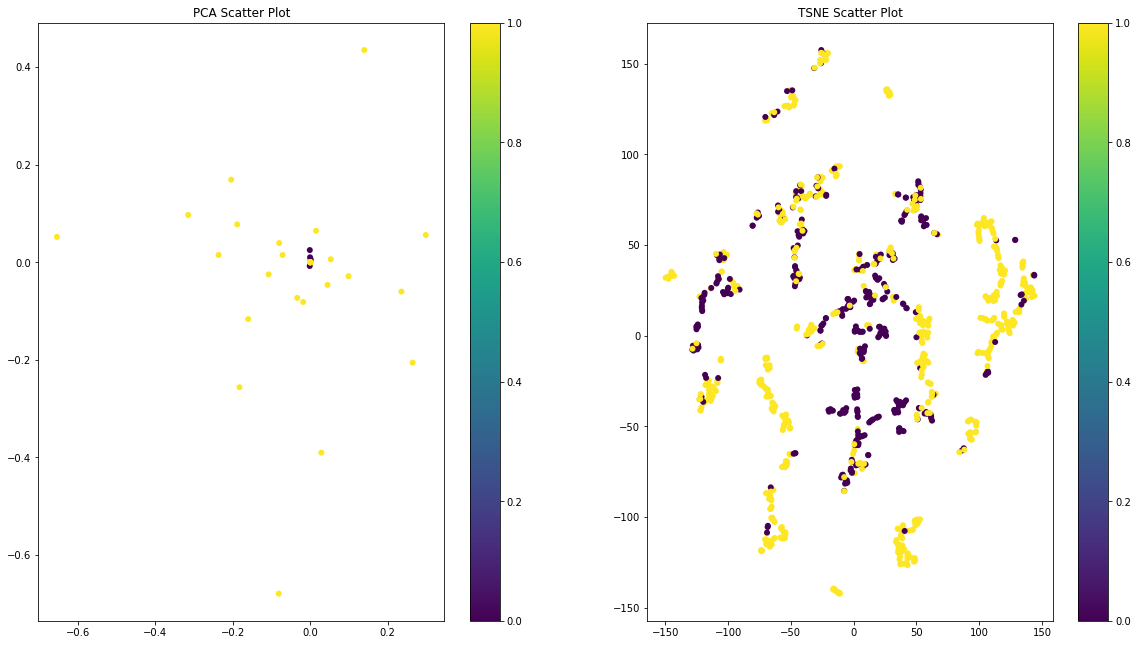

In [20]:
from matplotlib import pyplot as plt

# eliminated last row due to outlier

plt.figure(figsize = (20,11))
plt.subplot(121)
plt.scatter(footprint_pca.components_[:,0], footprint_pca.components_[:,1], c = footprint_label[:36], edgecolor = "None")
plt.colorbar()
plt.title('PCA Scatter Plot')
plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = footprint_label,  edgecolor = "None")
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

In the PCA there does appear to be somme clustering of low quality scored images however high quality images are spread out and seem to not have similar characteristics

In the TSNE plt there is grouping of some images but not in a very clear consistent pattern for both low and high quality.

This emphasizes that the features that we have may not be sufficient or that the scoring is inconsistent and doesn't follow a particular standard.



## Feature by Feature Comparisons

Foe each feature we will use a historgram to analyze data distributions and identify characteristics that may have higher incidences for imagss deemed low quality or high quality.

In [21]:
import matplotlib.pyplot as plt

# separate dataset for low quality and high quality scored images
footprint_label = np.array(footprint_label)
lq_filter = footprint_label == 0
hq_filter = footprint_label == 1

# get number of features
columns = len(footprint_matrix[0])


In [27]:
# What are the low quality vs high quality score counts
lq_filter.sum(), hq_filter.sum()

(372, 639)

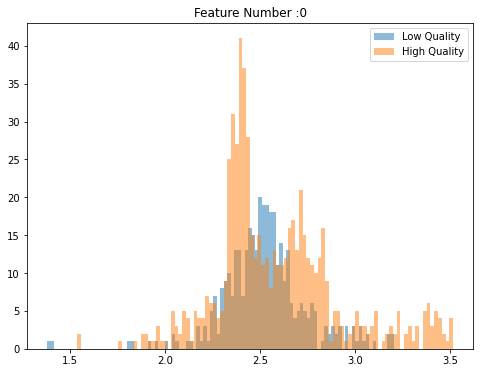

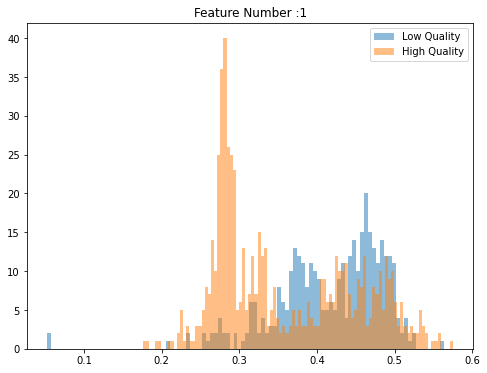

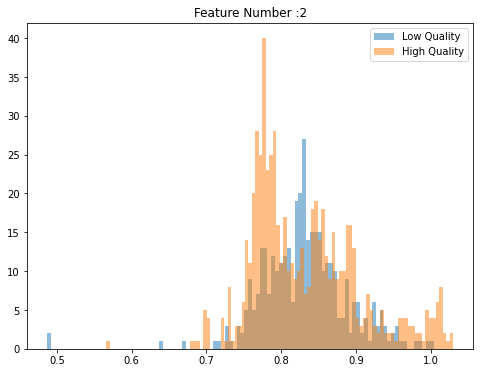

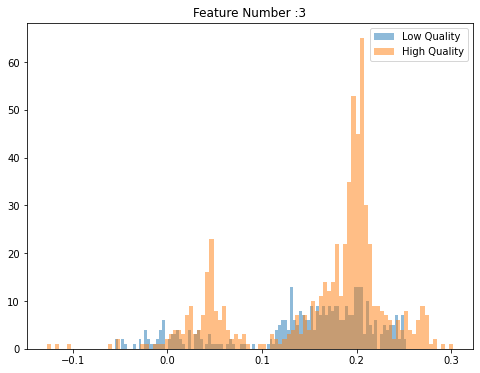

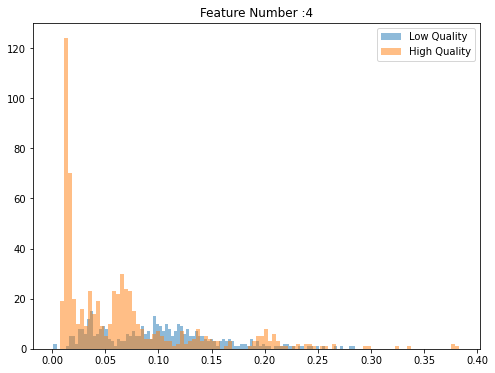

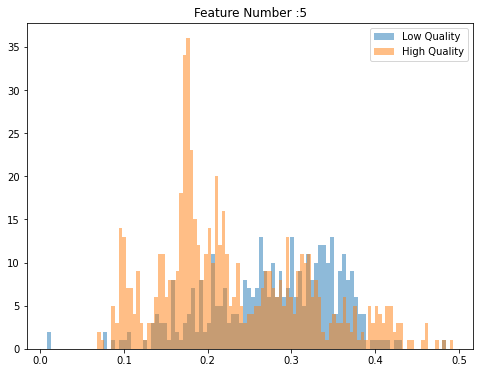

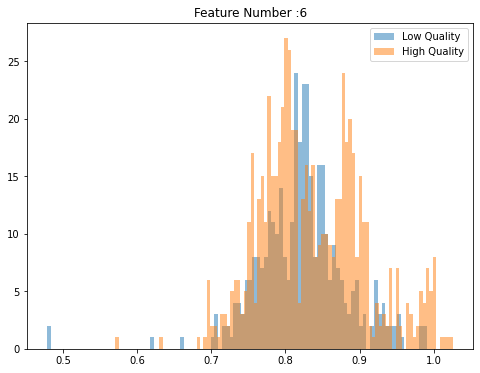

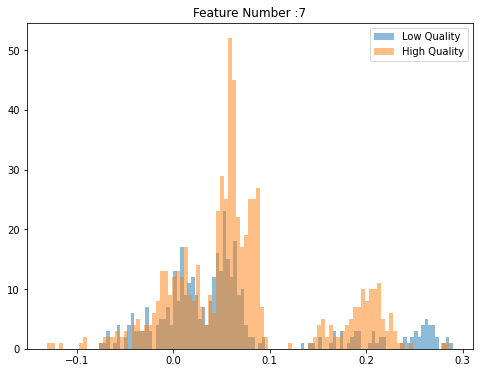

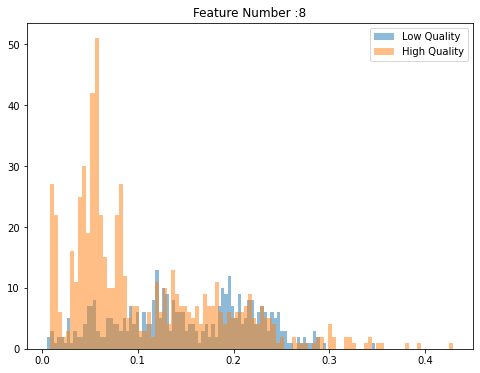

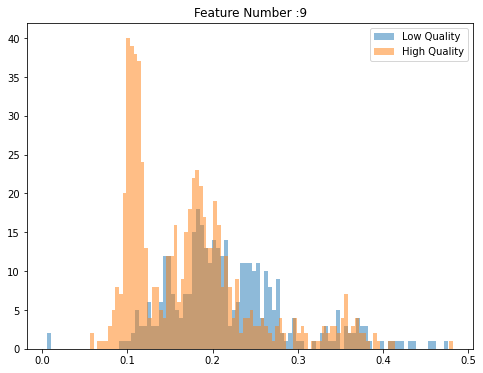

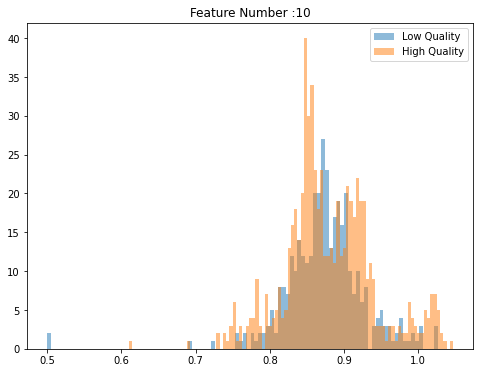

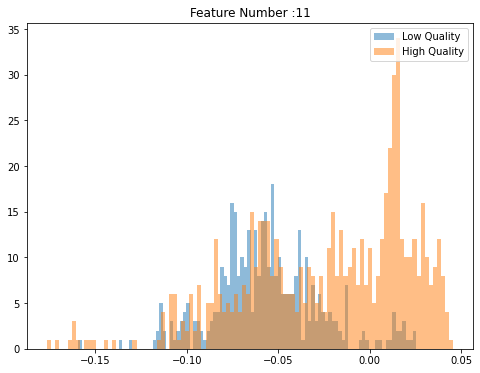

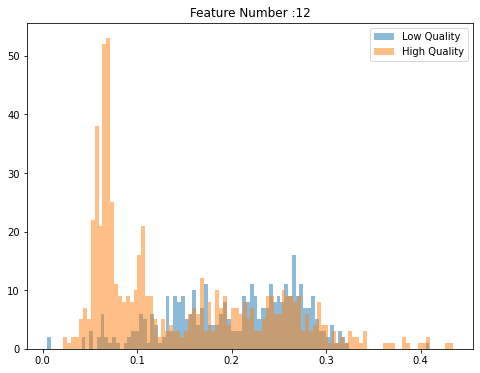

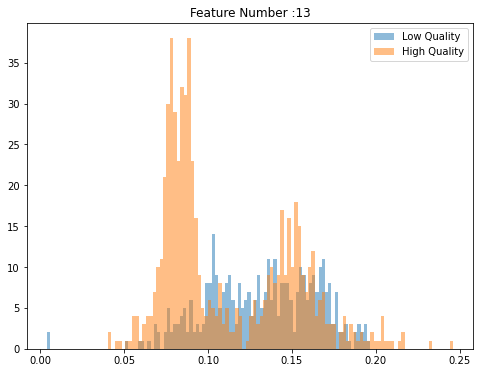

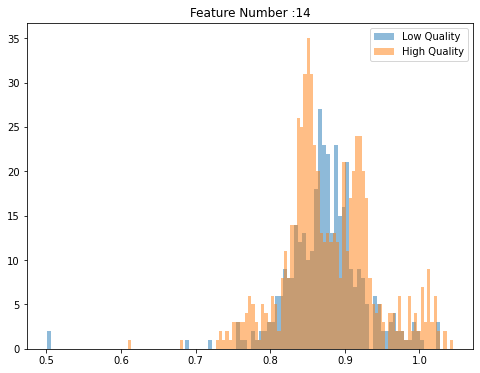

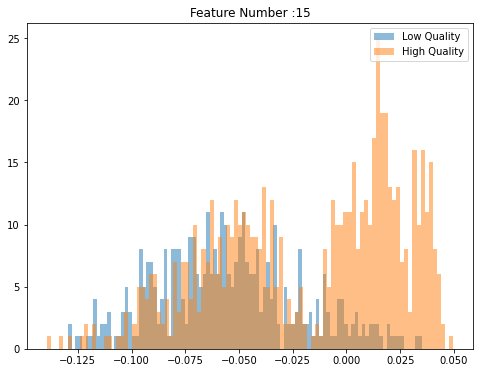

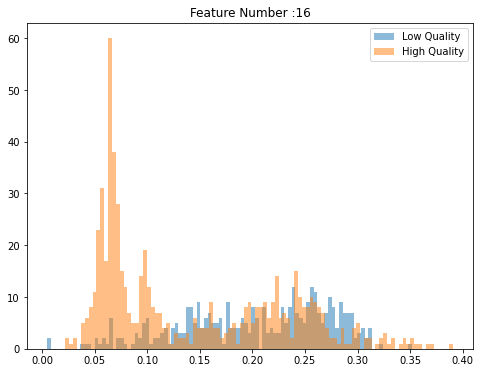

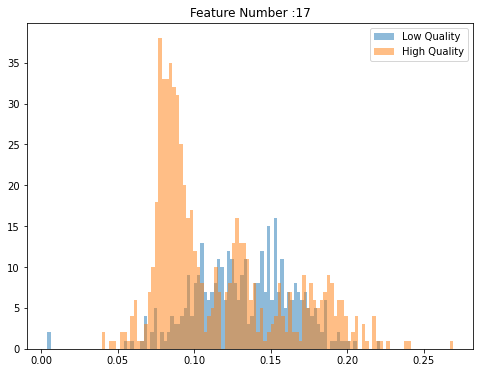

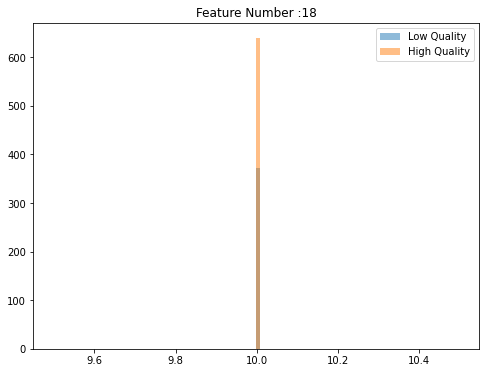

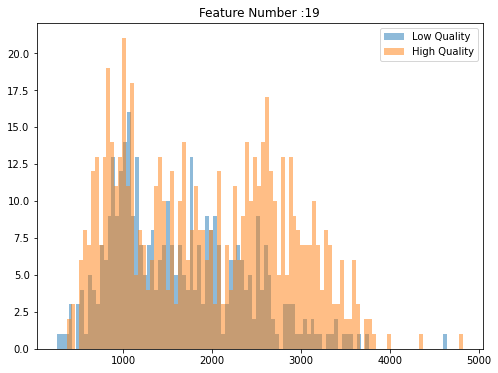

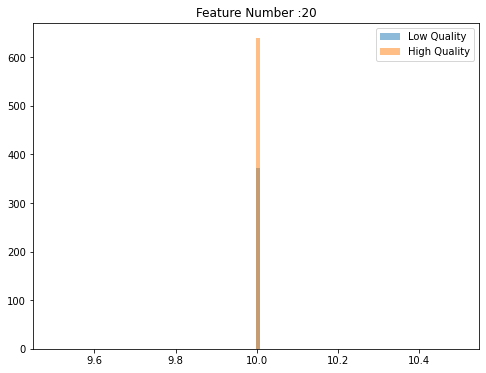

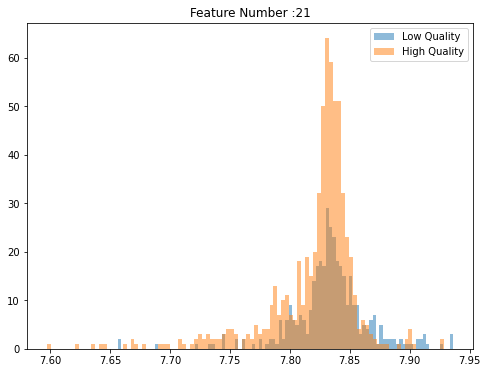

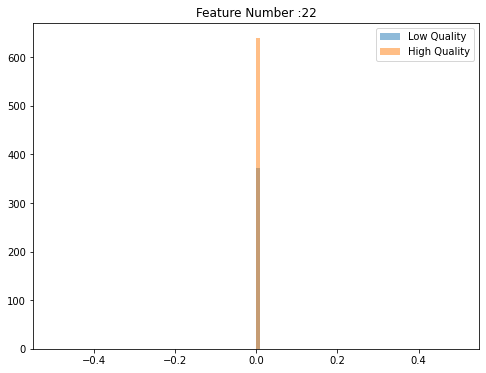

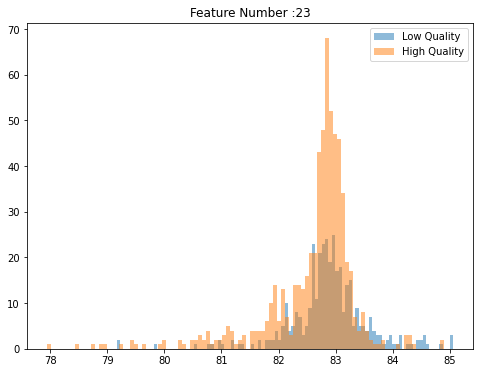

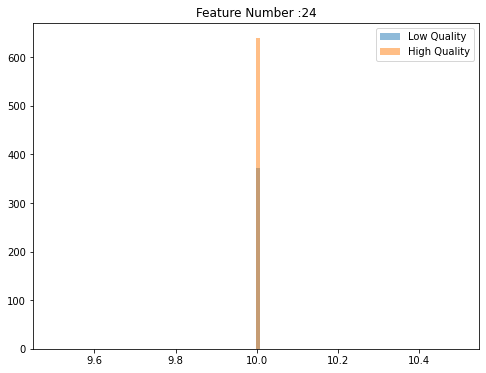

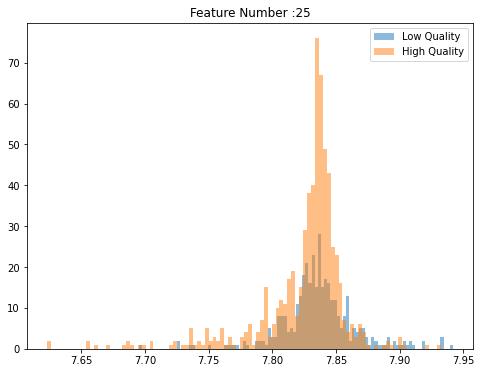

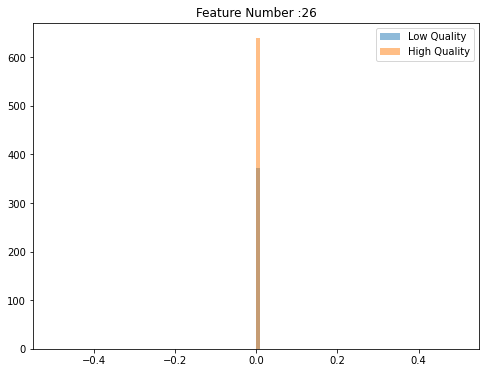

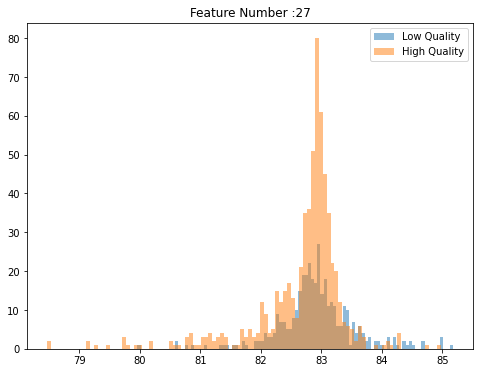

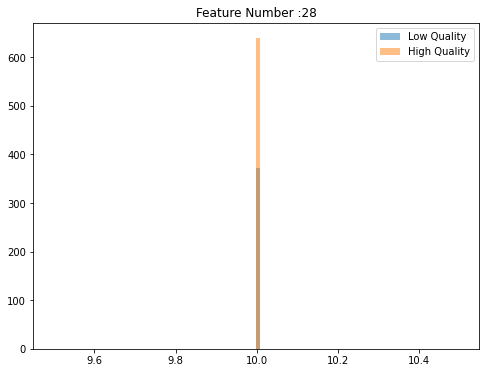

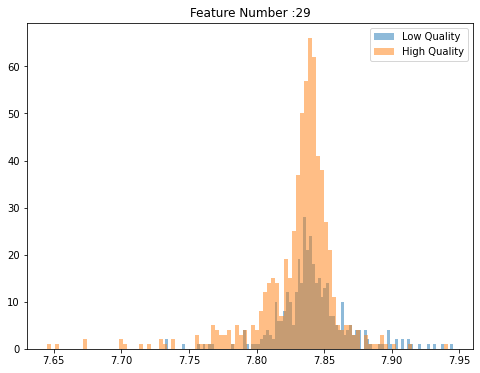

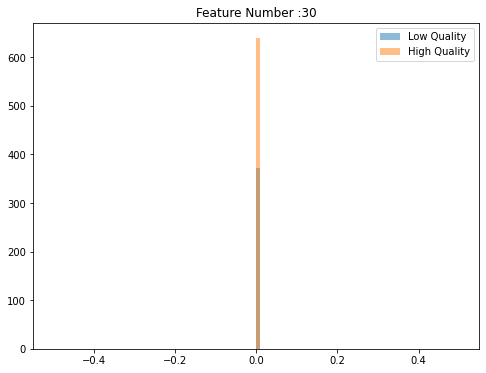

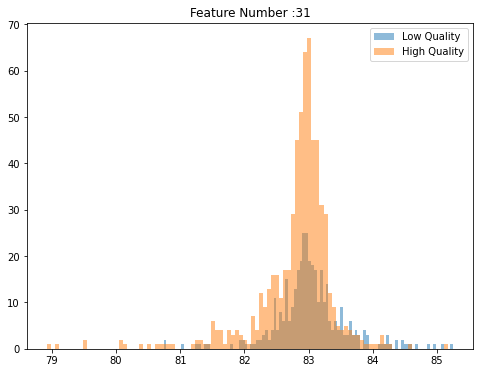

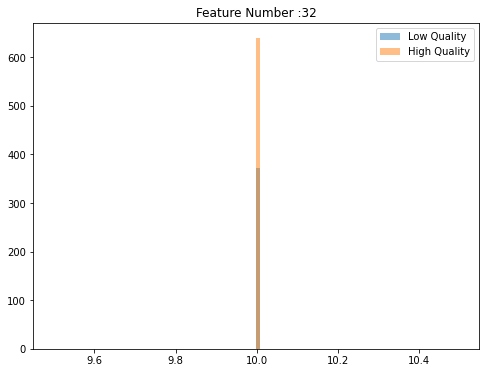

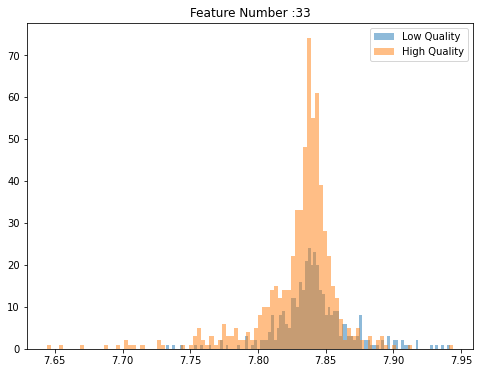

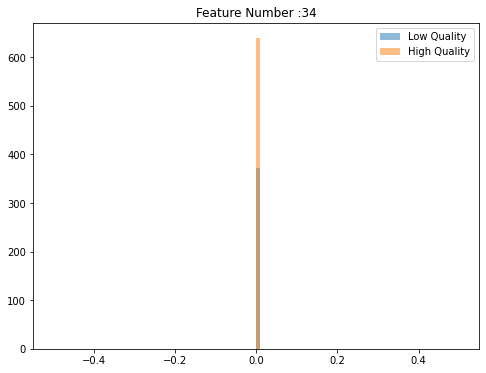

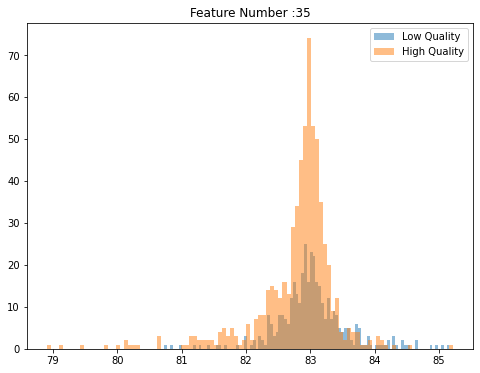

In [22]:
# dynamically generate histograme for review of distribution per characteristic

score_matrix = np.array(footprint_matrix)

for i in range(0,columns):
  lq_x = score_matrix[lq_filter, i]
  hq_x = score_matrix[hq_filter, i]

  plt.figure(figsize=(8,6))
  plt.title("Feature Number :" + str(i))
  plt.hist(lq_x, bins=100, alpha=0.5, label="Low Quality")
  plt.hist(hq_x, bins=100, alpha=0.5, label="High Quality")
  plt.legend(loc='upper right')
  plt.show() 


```
Feature Index:
0 - alpha_m, 1 - sigma_sq,
2 - alpha1, 3- N1, 4- lsq1**2, 5 - rsq1**2,  #(Vertical)
6 - alpha2, 7 - N2, 8 - lsq2**2, 9 - rsq2**2,  #(Horizontal)
10 - alpha3, 11 - N3, 12 - lsq3**2, 13 - rsq3**2,  #(Diagnoal 1)
14 - alpha4, 15 - N4, 16 - lsq4**2, 17 - rsq4**2,  #(Diagonal 2)
```

